In [29]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
from sim_utils import load_examples, Inputexample, CustomTextDataset, freeze_layers, train, test
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, AutoTokenizer
#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [8]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 4 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [9]:
path_5shot = f'../../../../NLP/NLP/Assignment/solutions/HWU64/train_5/'
valid_path = f'../../../../NLP/NLP/Assignment/solutions/HWU64/valid/'
test_path =  f'../../../../NLP/NLP/Assignment/solutions/HWU64/test/'

In [10]:
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

In [11]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

print("number of class :",num_class)

===== small train set ====
Train on Cross Entropy loss
len of dataset : 320
===== validation set ====
Train on Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Cross Entropy loss
len of dataset : 1076
number of class : 64


In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig

In [13]:
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

In [14]:
simcse = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

In [15]:
config = AutoConfig.from_pretrained("bert-base-uncased")
config.num_labels = num_class
model = AutoModelForSequenceClassification.from_config(config)
print("classifier change accordingly to num_class: ",model.classifier)

classifier change accordingly to num_class:  Linear(in_features=768, out_features=64, bias=True)


In [16]:
with torch.no_grad():
    
    for new_name, new_param in model.named_parameters():

        new_keys = new_name.split(".")

        for old_name, old_param in simcse.named_parameters():

            old_keys = old_name.split(".")

            if new_keys[1:] == old_keys:
                # print("-----------------------")
                # print(new_keys[1:])
                # print(old_keys)
                # print("-----------------------")
                # if new_param.shape == old_param.shape
                # feed old weight to new network
                model.state_dict()[new_name].data.copy_(old_param)
                
                assert torch.all(model.state_dict()[new_name] == simcse.state_dict()[old_name])
                                
print("Done with feed old weight to new architecure")     

Done with feed old weight to new architecure


In [17]:
model = freeze_layers(model,freeze_layers_count=12)

classifier.weight
classifier.bias


In [18]:
optimizer= AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [19]:
train_log, valid_log = train(model,optimizer,train_loader,valid_loader,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.9654583260416985, 		 Training acc: 0.21250000596046448
train correct :  tensor(68, device='cuda:3')
train total : 320
 Validation Loss: 0.7595803088415067, 		 Validation acc: 0.5901486873626709
valid correct :  tensor(635, device='cuda:3')
valid total : 1076
Validation Loss Decreased(inf--->0.759580) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.5963700287044048, 		 Training acc: 0.8062500357627869
train correct :  tensor(258, device='cuda:3')
train total : 320
 Validation Loss: 0.5444074996563582, 		 Validation acc: 0.6988847255706787
valid correct :  tensor(752, device='cuda:3')
valid total : 1076
Validation Loss Decreased(0.759580--->0.544407) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.369661664403975, 		 Training acc: 0.8812500238418579
train correct :  tensor(282, device='cuda:3')
train total : 320
 Validation Loss: 0.4285378533114288, 		 Validation acc: 0.702602207660675
valid correct :  tensor(756, device

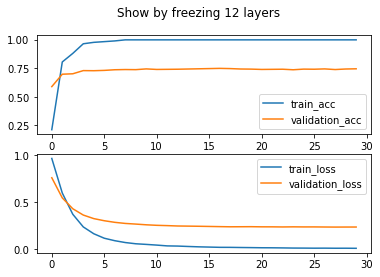

In [23]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [24]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 794
total : 1076


In [25]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 73.7918215613383 %


In [27]:
PATH = f'../../../fewshot_models/model_64_train_5.pth'
best_model = AutoModelForSequenceClassification.from_config(config)
# Model class must be defined somewhere
best_model.load_state_dict(torch.load(PATH))
best_model = best_model.to(device)

In [30]:
test_acc = test(best_model,device=device,label_maps=label_maps,test_loader=test_loader,data_size=len(test_data),tokenizer=tokenizer)

correct : 777
total : 1076


In [31]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 72.21189591078067 %
